# Analysis of the Medical Center

*Irina Dabaeva*
*25.12.2023*

#### Goal:
    Analyze the price change between two years (2021, and 2022). Find possible reasons behind this.
    
#### Dataset: 
    https://disk.yandex.ru/d/Q2o2zUlRpLwpfQ

#### Data description: 
    record_id - unique ID of observation;
    service_date - date the service provided;
    service_name - name of the service provided;
    service_number - number of services;
    service_amount - check (price of service provided in rub.);
    insured - unique ID of a patient;
    sex_id - gender;
    age_for_service_date - age of the patient.
    
**Table of contents:**

1. [Basic Data Analysis](#Basic-Data-Analysis)


2. [Data Preprocessing](#Data-Preprocessing)


3. [EDA](#EDA)
 

4. [Conclusion](#Conclusion)

In [41]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot

## Basic Data Analysis

In [42]:
df = pd.read_excel('data_test_task_2022.xlsx')
df.head(15)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.0,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.0,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.0,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.0,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.0,26


In [43]:
# to print basic info
def print_info():
    print(df.info(), '\n')
    print('Missing values:')
    print(df.isna().any(), '\n')
    print('Duplicates:')
    print(df[df.duplicated()])

In [44]:
print_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB
None 

Missing values:
record_id               False
service_date            False
service_name            False
service_amount          False
service_number          False
insured                 False
sex_id                   True
age_for_service_date    False
dtype: bool 

Duplicates:
Empty DataFrame
Columns: [recor

Dataset contains 85369 observations. Besides, 'sex_id' is the only column containing missing values.

In [45]:
pd.DataFrame(df.isna().mean()*100).style.background_gradient('coolwarm')

,0
record_id,0.000000
service_date,0.000000
service_name,0.000000
service_amount,0.000000
service_number,0.000000
insured,0.000000
sex_id,0.024599
age_for_service_date,0.000000


The percentage of missing values in the column 'sex_id' is insignificant.

In [46]:
len(df['service_name'].unique())

875

In [47]:
#sorted(df['service_name'].unique())

**Therefore:**

- The dimensions of our dataset are 8 x 85369;

- Column 'sex_id' contains 21 missing values;

- There are 875 unique services;

- No identical duplicates.

## Data Preprocessing

Since some of the services were renamed in 2022, it is a good practice to transform them to a common format.

In [48]:
replace_from = ['Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность', 
                'Исследование кала на дисбактериоз кишечника с определением чувствительности к фагам', 
                'Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ', 
                'Консультация ведущего специалиста перед вакцинацией', 'Консультация педиатра перед вакцинацией', 'Обработка вульвы',
                'Перевязка гнойных ран (более 4см,кв.)', 'Перевязка гнойных ран (менее 4см,кв.)', 'Перевязка чистая (более 4 см,кв.)',  'Перевязка чистая (менее 4 см,кв.)',
                'Ультразвуковое исследование гинекология трансвагинально с ДС сосудов', 'Удаление серной пробки  (за одно ухо)',
                'Удаление серных пробок (за ухо)', 'Ударно-волновая терапия (1 сеанс)']

replace_to = ['Гемостазиограмма (Коагулограмма: Антитромбин III, АЧТВ, МНО, Плазминоген, Протромбиновое время, РФМК, Тромбиновое время, Фибриноген, Активность факторов протромбинового комплекса % по Квику)', 
              'Исследование кала на дисбактериоз кишечника с определением чувствительности к фагам и антибиотикам', 
              'Комплекс на операцию: (Общий анализ крови (без лейкоцитарной формулы), СОЭ, Лейкоцитарная формула, Группа крови, Rh-фактор, Келл, АЛТ (аланинаминотрансфераза), АСТ (аспартатаминотрансфераза), Билирубин общий, Глюкоза крови, Калий, Натрий, Креатинин, Моче',
              'Консультация врача перед вакцинацией','Консультация врача перед вакцинацией', 'Обработка вульвы лекарственными препаратами',
              'Перевязка гнойных ран (более 4 кв.см.)', 'Перевязка гнойных ран (менее 4 кв.см.)', 'Перевязка чистая (более 4 кв.см.)',  'Перевязка чистая (менее 4 кв.см.)',
              'Ультразвуковое исследование гинекология трансвагинально с ДС сосудов (доктор медицинских наук, профессор, врач-эксперт)',
              'Удаление ушной серы с одной стороны', 'Удаление ушной серы с одной стороны', 'Ударно- волновая терапия (урология, гинекология), 1 сеанс']

df['service_name'] = df['service_name'].replace(replace_from, replace_to)
df['service_name'] = df['service_name'].replace('(', '')
df['service_name'] = df['service_name'].replace(')', '')
df['service_name'] = df.service_name.replace(r'\s+', ' ', regex=True)

In [49]:
len(df['service_name'].unique())

861

Let's separate services into different categories:

- MRI/CT scan
- therapy
- vaccination
- surgery
- massage
- radiography
- consultation
- additional services
- blood and other tests

In [50]:
def filter(x):
    x = x.lower()
    if (('мрт' in x) | ('мскт' in x)):
        return 'MRI/CT'
    elif (('лечебно' in x) | ('лечение' in x) | ('терапия' in x) | ('обработка' in x)):
        return 'therapy'
    elif 'вакцинация' in x:
        return 'vaccination'
    elif (('вскрытие' in x) | ('хирурги' in x) | ('удаление' in x)):
        return 'surgery'
    elif 'массаж' in x:
        return 'massage'
    elif 'рентгенография' in x:
        return 'radiography'
    elif (('прием' in x) | ('консультация' in x)):
        return 'consultation'
    elif (('снятие' in x) | ('наложение' in x) | ('перевязка' in x)):
        return 'add. services'
    else: return 'tests'
    
# divide services into categories 
df['category'] = df['service_name'].apply(filter)

In [51]:
(pd.pivot_table(df, values='record_id', index='category', aggfunc='count')
    .reset_index()
    .sort_values(by='record_id', ascending=False))

,category,record_id
6,tests,46246
2,consultation,26327
7,therapy,6021
4,radiography,2486
1,add. services,1953
3,massage,1841
5,surgery,349
0,MRI/CT,111
8,vaccination,35


'tests' is the category with the most observations (46246).

In [52]:
# create categories for 'age_for_service_date'
bins = [0, 2, 18, 35, 65, np.inf]
names = ['<2', '2-18', '18-35', '35-65', '65+']
df['age_group'] = pd.cut(df['age_for_service_date'], bins, labels=names)

In [53]:
# convert 'service_date' to datetime type
df['service_date'] = pd.to_datetime(df['service_date'], format='%Y-%m-%d')

# extract month and year
df['month'] = df['service_date'].dt.month
df['year'] = df['service_date'].dt.year
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,category,age_group,month,year
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26,consultation,18-35,1,2021
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26,tests,18-35,1,2021
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26,tests,18-35,1,2021
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26,tests,18-35,1,2021
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26,tests,18-35,1,2021


## EDA

In [54]:
# function to create pivot tables
def create_pivot(df_, val, ind, func):
    tmp = pd.pivot_table(df_, values=val, index=ind, aggfunc=func)
    return tmp

In [55]:
# function to plot
def set_plot(mode, df_, x_, y_, x_lbl, y_lbl, ttl, hue_='', lgd_title=''):
    if mode == 0:
        sns.barplot(df_, x=x_, y=y_)
    elif mode == 1:
        sns.catplot(data=df_, x=x_, y=y_, hue=hue_, kind="bar", legend=False)
        plt.legend(title=lgd_title)
    elif mode == 3:
        sns.catplot(data=df_, x=x_, y=y_, kind="bar", legend=False)
    plt.title(ttl)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.show()


    year  service_amount
0  2021        50561671
1  2022        48986662 



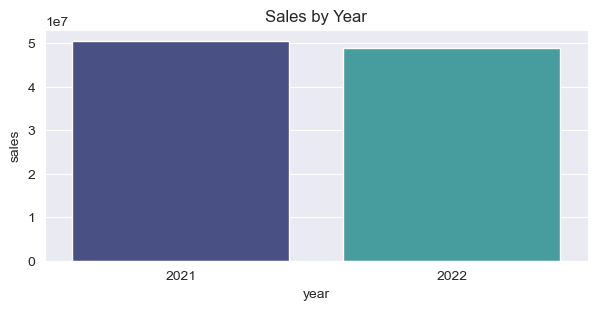

In [56]:
# set style
sns.set_style("darkgrid")    
custom_palette = sns.color_palette("mako", 2)
sns.set_palette(custom_palette)

# calculate revenue for each year
revenue_by_year = create_pivot(df, 'service_amount', 'year', 'sum')
revenue_by_year = revenue_by_year.reset_index().sort_values(by='service_amount', ascending=False)
print('\n',revenue_by_year,'\n')

# plot revenue for each year
plt.figure(figsize=(7, 3))
set_plot(0, revenue_by_year, "year", "service_amount", 'year', 'sales', 'Sales by Year')

As we can see total sales for each year are relatively the same.

In [57]:
# calculate total sales for each month of 2021 and 2022
revenue_by_month = create_pivot(df, 'service_amount', ['year', 'month'], 'sum').reset_index()

In [58]:
# calculate revenue % for each month of 2021 and % diff comapred to previous month
revenue_by_month_2021 = revenue_by_month.query('year==2021').copy()
revenue_by_month_2021['fraction'] = revenue_by_month_2021['service_amount']*100/sum(revenue_by_month_2021['service_amount'])
revenue_by_month_2021['pct_change'] = revenue_by_month_2021['service_amount'].pct_change(periods=1) * 100
print(revenue_by_month_2021, '\n')

# same as above for 2022
revenue_by_month_2022 = revenue_by_month.query('year==2022').copy()
revenue_by_month_2022['fraction'] = revenue_by_month_2022['service_amount']*100/sum(revenue_by_month_2022['service_amount'])
revenue_by_month_2022['pct_change'] = revenue_by_month_2022['service_amount'].pct_change(periods=1) * 100
print(revenue_by_month_2022)

    year  month  service_amount   fraction  pct_change
0   2021      1         2265931   4.481519         NaN
1   2021      2         2379125   4.705392    4.995474
2   2021      3         3927248   7.767243   65.071108
3   2021      4         4380487   8.663652   11.540881
4   2021      5         4298978   8.502444   -1.860729
5   2021      6         4522585   8.944691    5.201399
6   2021      7         3872209   7.658388  -14.380625
7   2021      8         4310989   8.526200   11.331516
8   2021      9         4782859   9.459456   10.945748
9   2021     10         6063580  11.992444   26.777310
10  2021     11         4747330   9.389187  -21.707473
11  2021     12         5010350   9.909384    5.540377 

    year  month  service_amount   fraction  pct_change
12  2022      1         4800320   9.799239         NaN
13  2022      2         5298235  10.815669   10.372538
14  2022      3         6451060  13.169013   21.758661
15  2022      4         8035080  16.402587   24.554414
16  2022

In 2021:

- October was the most productive month (almost 12% of annual sales);
- Right after October, we have a decrease in sales. November sales fell by 22% compared to October;
- In March, there was a sudden increase in sales by 65% compared to the previous month.

In 2022:

- Dataset contains data until August;
- We can see an increase in sales until April and a downfall in the next months;
- In August sales dropped by 40%.

In [59]:
# difference in revenue between 2021 and 2022
merged_revenue= pd.DataFrame()
merged_revenue['month'] = revenue_by_month_2021['month']
merged_revenue['amount_2021'] = revenue_by_month_2021['service_amount']
merged_revenue = pd.merge(merged_revenue, revenue_by_month_2022[['service_amount', 'month']], on='month', how='outer')
merged_revenue = merged_revenue.rename(columns={'service_amount':'amount_2022'})
merged_revenue['diff'] = merged_revenue['amount_2022'] / merged_revenue['amount_2021']

merged_revenue

,month,amount_2021,amount_2022,diff
0,1,2265931,4800320.0,2.118476
1,2,2379125,5298235.0,2.226968
2,3,3927248,6451060.0,1.642641
3,4,4380487,8035080.0,1.834289
4,5,4298978,7588110.0,1.765096
5,6,4522585,6879580.0,1.521161
6,7,3872209,6216498.0,1.605414
7,8,4310989,3717779.0,0.862396
8,9,4782859,NaN,NaN
9,10,6063580,NaN,NaN


In [60]:
pal = sns.color_palette("mako", len(merged_revenue))

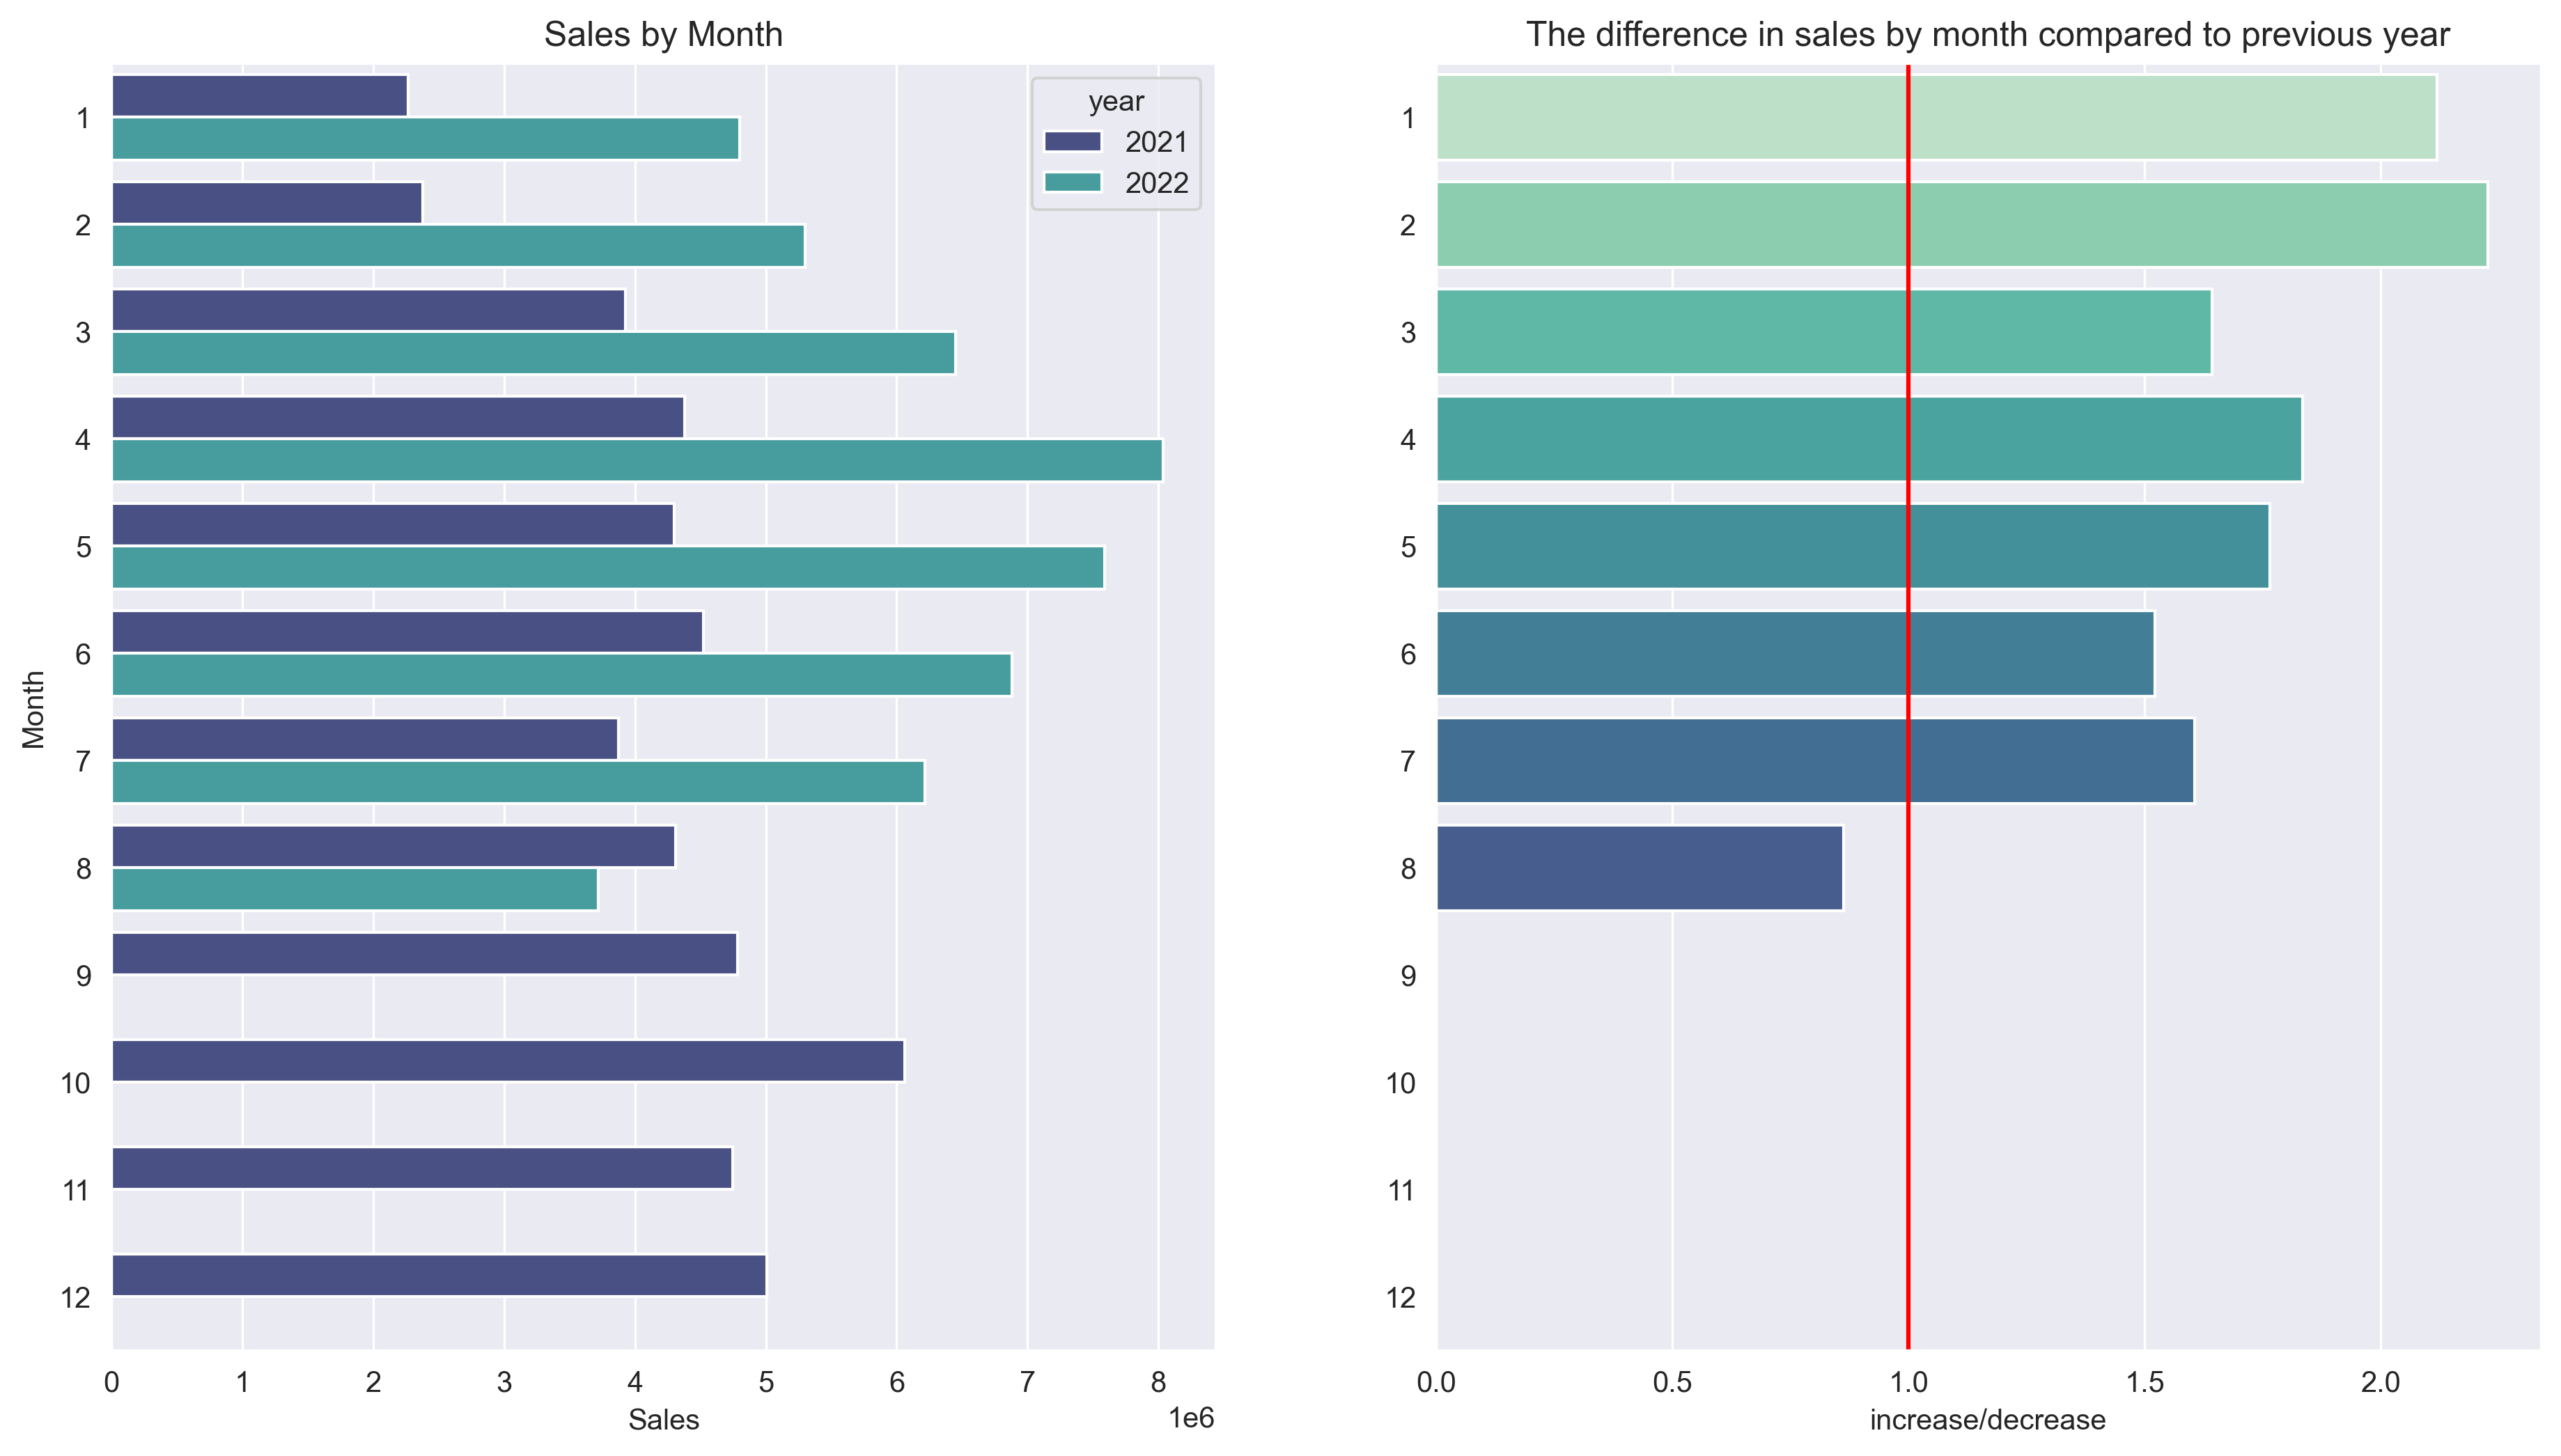

In [61]:
fig, ax =plt.subplots(1,2,dpi=300)
sns.barplot(data=revenue_by_month, x='service_amount', y='month', orient="h", hue='year', ax=ax[0])
ax[0].set_xlabel('Sales')
ax[0].set_ylabel('Month')
ax[0].set_title('Sales by Month')
sns.barplot(data=merged_revenue, x='diff', y='month', orient='h', ax=ax[1], palette=np.array(pal[::-1]))
ax[1].axvline(x = 1, ymin = 0, ymax = 1, color = "red") 
ax[1].set_xlabel('increase/decrease')
ax[1].set_ylabel('')
ax[1].set_title('The difference in sales by month compared to previous year')
fig.set_figwidth(15)
fig.set_figheight(8)

Comparing sales by months between 2021 and 2022, we can notice that sales were higher in 2022 over the whole period except August.

In [62]:
labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],subplot_titles=("<b>2021<b>","<b>2022<b>"))
fig.add_trace(go.Pie(labels=labels, values=revenue_by_month_2021['service_amount'], name=''), row=1, col=1)
fig.add_trace(go.Pie(labels=labels, values=revenue_by_month_2022['service_amount'], name=''), row=1, col=2)
fig.show()

The second half of 2021 was the most profitable whereas it's the first half in 2022.

    month  service_amount
5       6    10396.747126
9      10    10259.864636
3       4     9380.057816
4       5     9166.264392
11     12     8947.053571
7       8     8833.993852
10     11     8807.662338
2       3     8805.488789
6       7     8662.659955
8       9     8556.098390
0       1     7922.835664
1       2     7699.433657


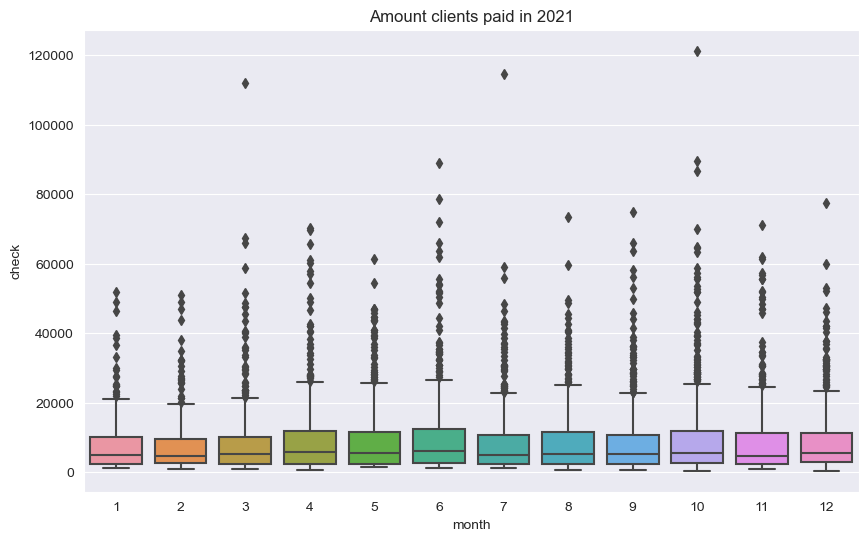

In [63]:
# calculate check per month
tmp_2021 = df.query('year==2021')
amount_by_client = create_pivot(tmp_2021, 'service_amount', ['month', 'insured'], 'sum').reset_index()
amount_by_client_ = create_pivot(amount_by_client,'service_amount', 'month', 'mean').reset_index().sort_values(by='service_amount', ascending=False)
print(amount_by_client_)
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax = sns.boxplot(x='month', y='service_amount', data=amount_by_client)
ax.set_xlabel('month')
ax.set_ylabel('check')
ax.set_title('Amount clients paid in 2021')
plt.show()

   month  service_amount
7      8    10355.930362
3      4    10119.748111
2      3     9744.803625
6      7     9698.124805
4      5     9461.483791
5      6     9321.924119
1      2     8995.305603
0      1     8649.225225


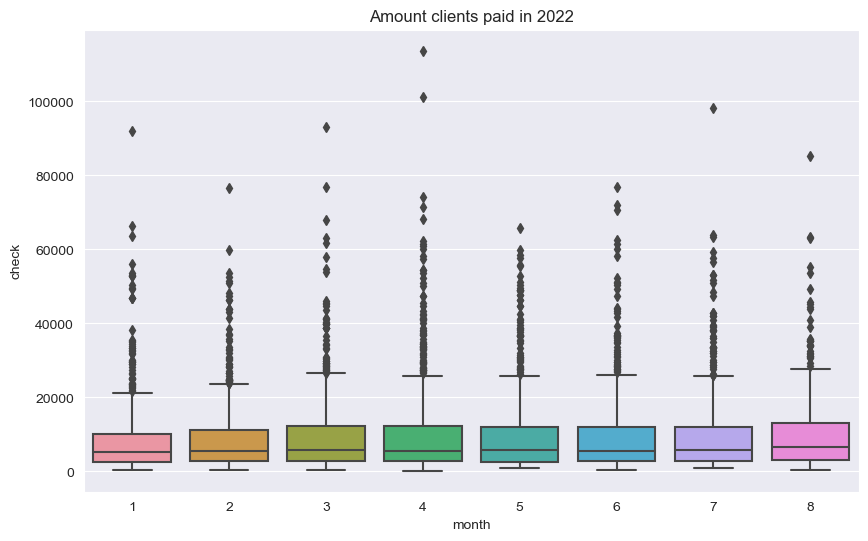

In [64]:
tmp_2022 = df.query('year==2022')
amount_by_client = create_pivot(tmp_2022, 'service_amount', ['month', 'insured'], 'sum').reset_index()
amount_by_client_ = create_pivot(amount_by_client,'service_amount', 'month', 'mean').reset_index().sort_values(by='service_amount', ascending=False)
print(amount_by_client_)
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax = sns.boxplot(x='month', y='service_amount', data=amount_by_client)
ax.set_xlabel('month')
ax.set_ylabel('check')
ax.set_title('Amount clients paid in 2022')
plt.show()

The average check per single visit is slightly higher in 2022.

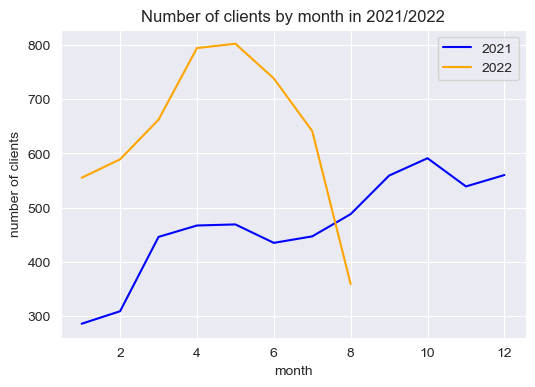

In [65]:
clients_2021 = create_pivot(tmp_2021, 'insured', 'month', lambda x: len(x.unique())).reset_index()
clients_2022 = create_pivot(tmp_2022, 'insured', 'month', lambda x: len(x.unique())).reset_index()

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)
sns.lineplot(x='month', y='insured', data=clients_2021, hue=2021, palette=['blue'])
sns.lineplot(x='month', y='insured', data=clients_2022, hue=2022, palette=['orange'])
ax.set_xlabel('month')
ax.set_ylabel('number of clients')
ax.set_title('Number of clients by month in 2021/2022')
plt.show()

In the year 2021, we can notice a gradual increase in number of clients over the year (with some seasonal drops). Whereas in 2022 there was a noticeable increase till May followed by a sudden drop afterwards. 

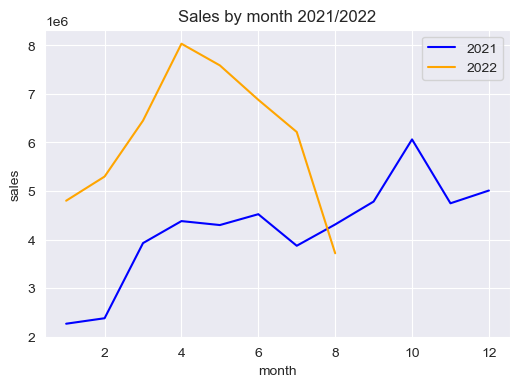

In [66]:
rev_2021 = create_pivot(tmp_2021, 'service_amount', 'month', 'sum').reset_index()
rev_2022 = create_pivot(tmp_2022, 'service_amount', 'month', 'sum').reset_index()

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)
sns.lineplot(x='month', y='service_amount', data=rev_2021, hue=2021, palette=['blue'])
sns.lineplot(x='month', y='service_amount', data=rev_2022, hue=2022, palette=['orange'])
ax.set_xlabel('month')
ax.set_ylabel('sales')
ax.set_title('Sales by month 2021/2022')
plt.show()

There is a relationship between amount of clients and total sales. The moment clients stopped showing up, sales decreased. Therefore we can suggest the hypothesis that **the average service price changed due to the change in the number of clients.**

In [67]:
def plot_pointplot(df1,df2,x_,y_, hue_,xlbl,ylbl,ttl,pltt):
    sns.pointplot(data=df1, x=x_, y=y_, hue=hue_, ax=ax[0],palette=pltt)
    ax[0].set_xlabel(xlbl)
    ax[0].set_ylabel(ylbl)
    ax[0].set_title(ttl + ' in 2021')
    sns.pointplot(data=df2, x=x_, y=y_, hue=hue_, ax=ax[1],palette=pltt)
    ax[1].set_xlabel(xlbl)
    ax[1].set_ylabel('')
    ax[1].set_title(ttl + ' in 2022')

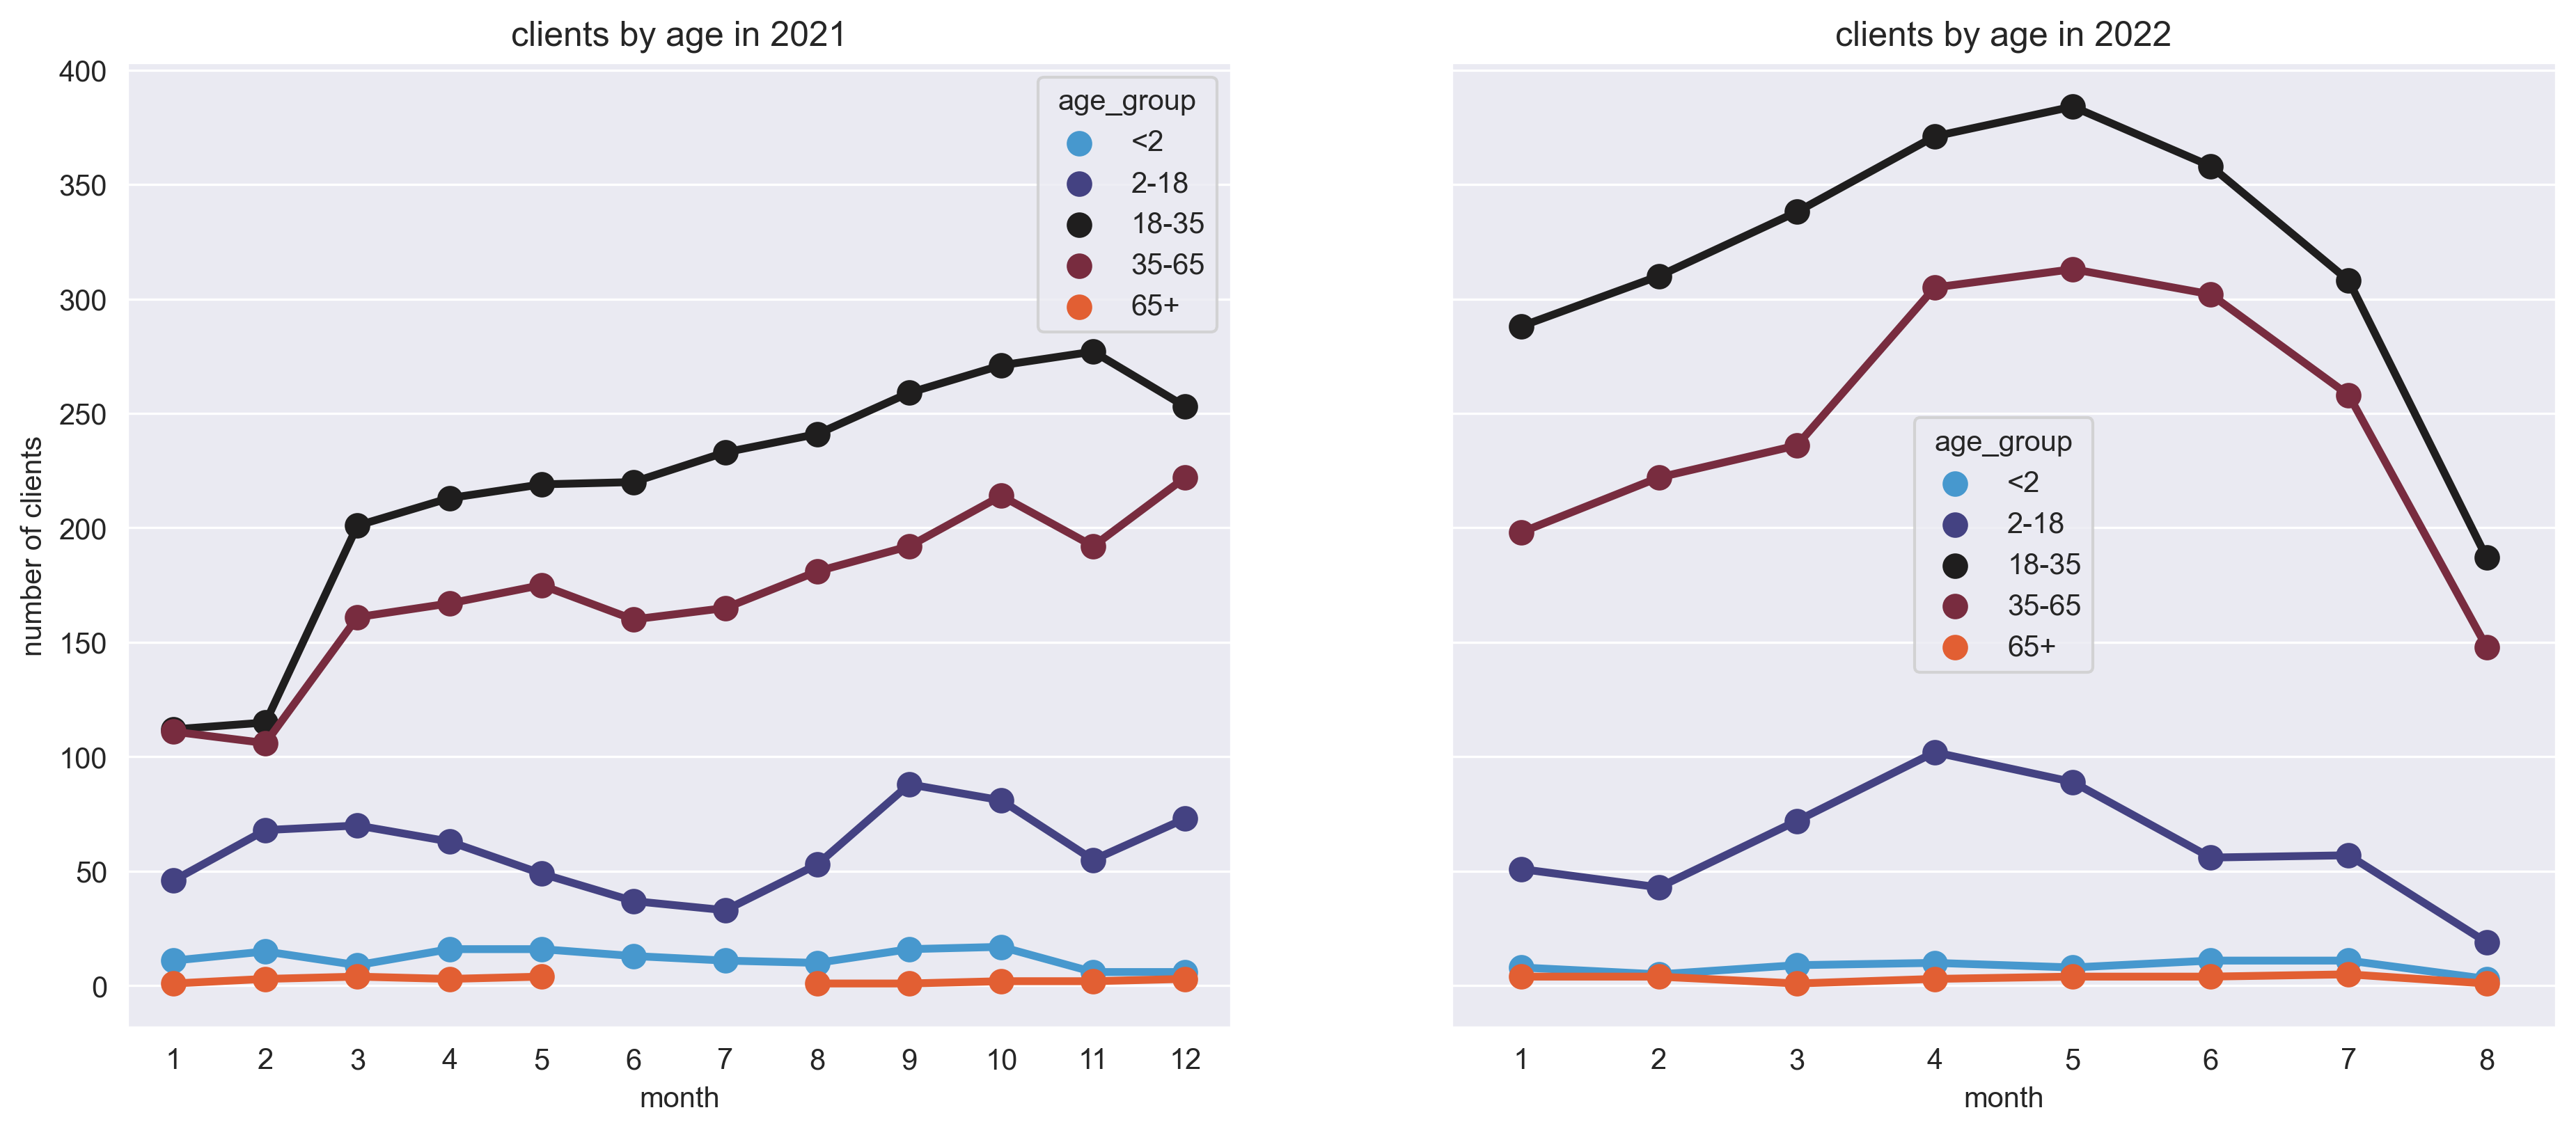

In [68]:
clients_2021 = create_pivot(tmp_2021, 'insured', ['month', 'age_group'], lambda x: len(x.unique())).reset_index()
clients_2022 = create_pivot(tmp_2022, 'insured', ['month', 'age_group'], lambda x: len(x.unique())).reset_index()

fig, ax =plt.subplots(1,2,dpi=300,sharey=True)
plot_pointplot(clients_2021,clients_2022,'month','insured','age_group','month','number of clients','clients by age','icefire')
fig.set_figwidth(15)
fig.set_figheight(6)

The main client base is people from 18 to 65 y.o.

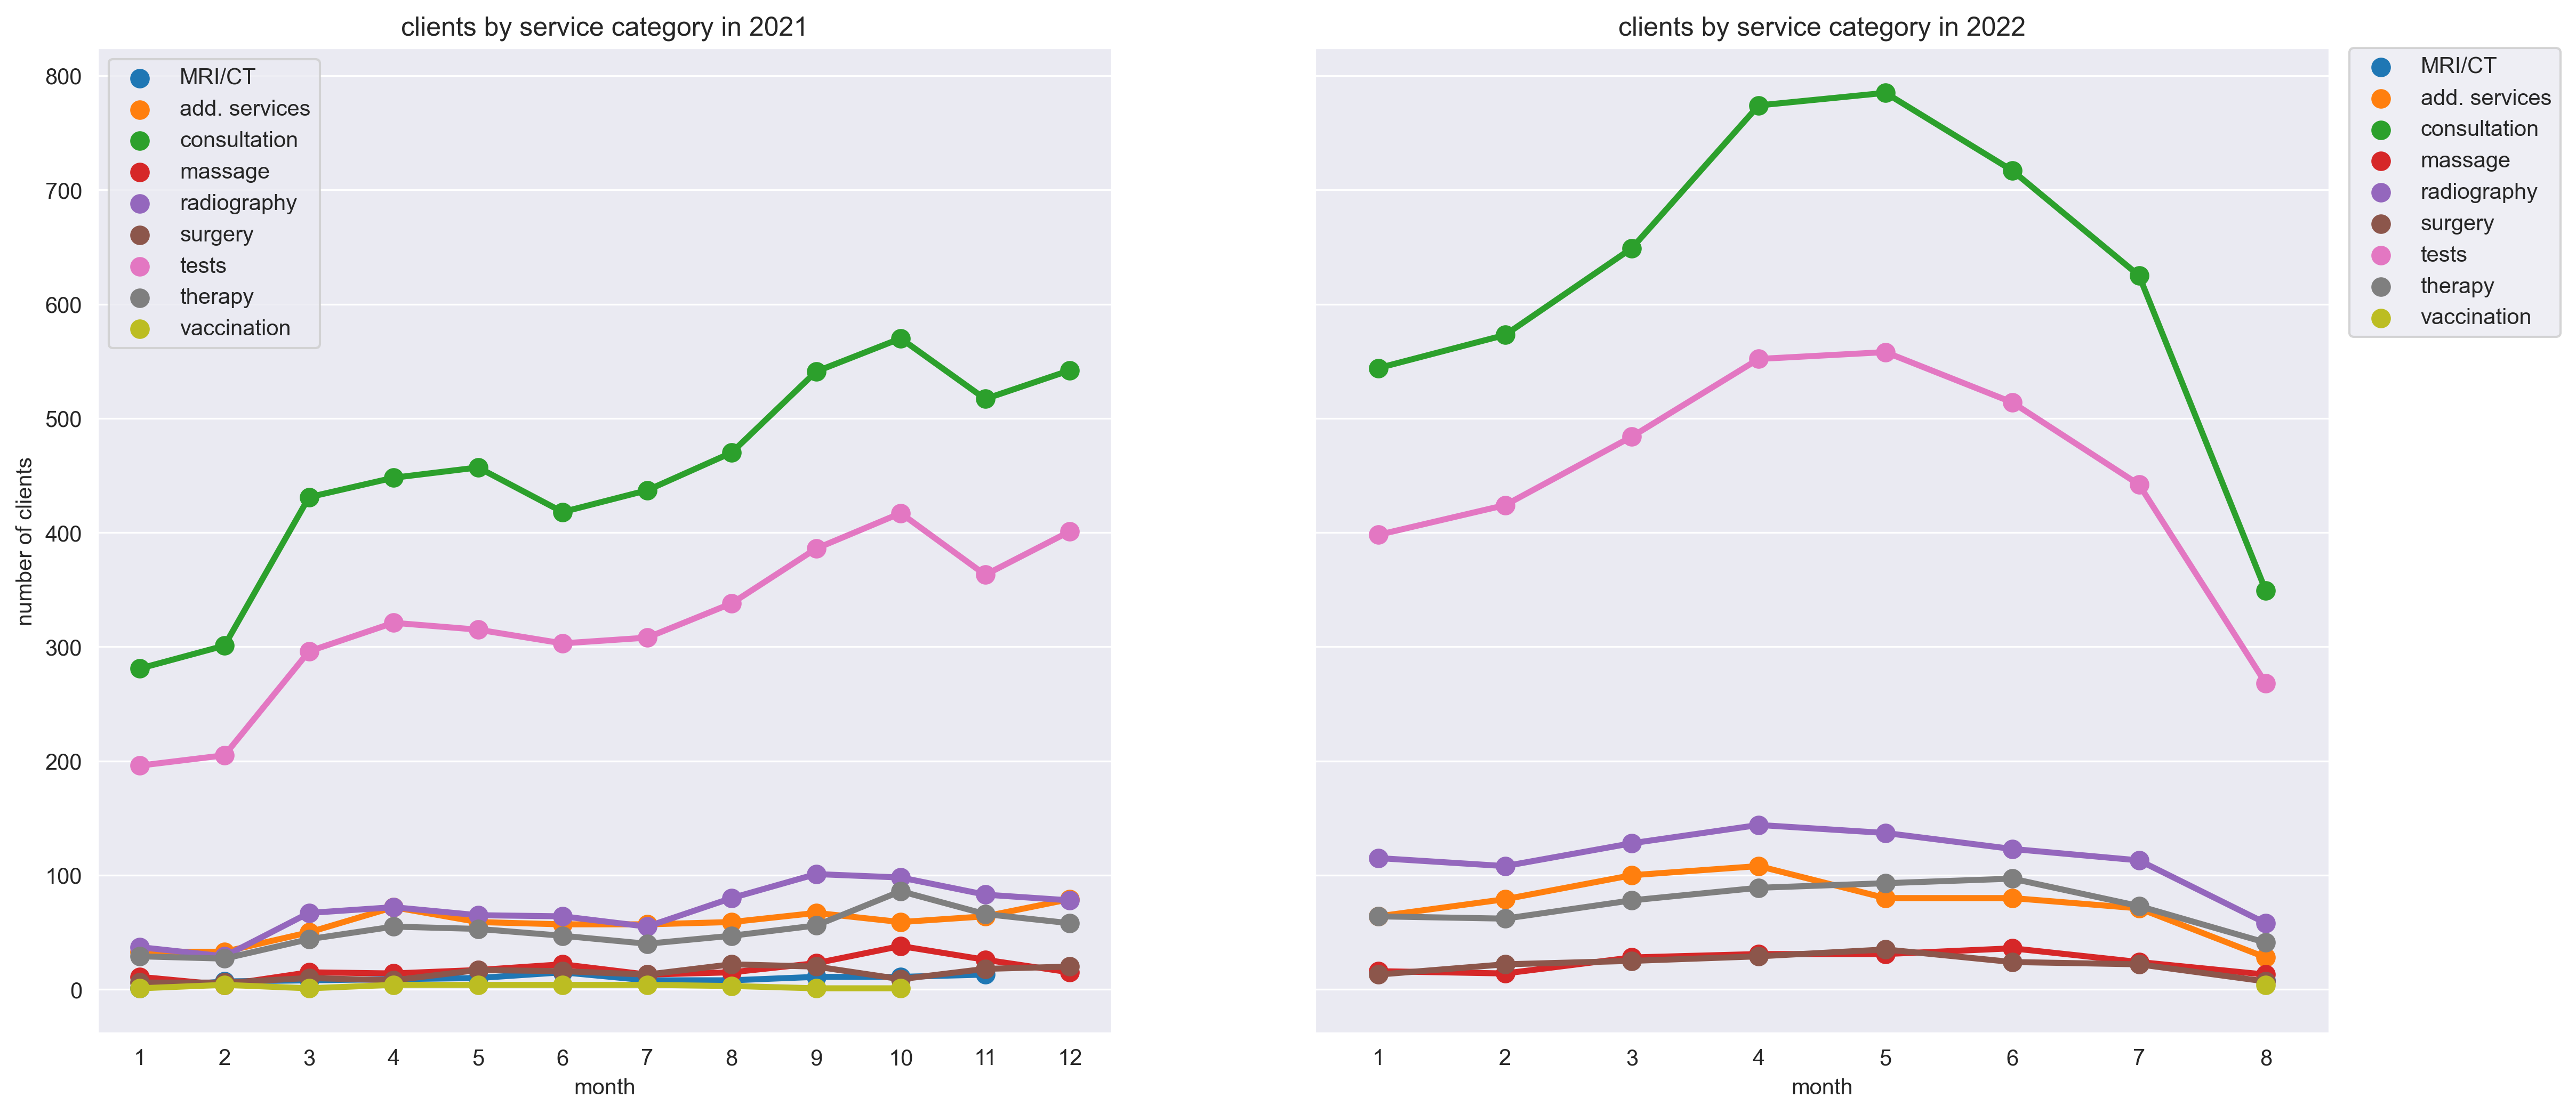

In [69]:
by_category_2021 = create_pivot(tmp_2021, 'insured', ['month', 'category'], lambda x: len(x.unique())).reset_index().sort_values(by='category')
by_category_2022 = create_pivot(tmp_2022, 'insured', ['month', 'category'], lambda x: len(x.unique())).reset_index().sort_values(by='category')

fig, ax =plt.subplots(1,2,dpi=300,sharey=True)
plot_pointplot(by_category_2021,by_category_2022,'month','insured','category','month','number of clients','clients by service category','tab10')
ax[0].legend(loc='upper left')
ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.set_figwidth(18)
fig.set_figheight(8)

In 2022 there is a decrease in demand for all types of service from April to May.

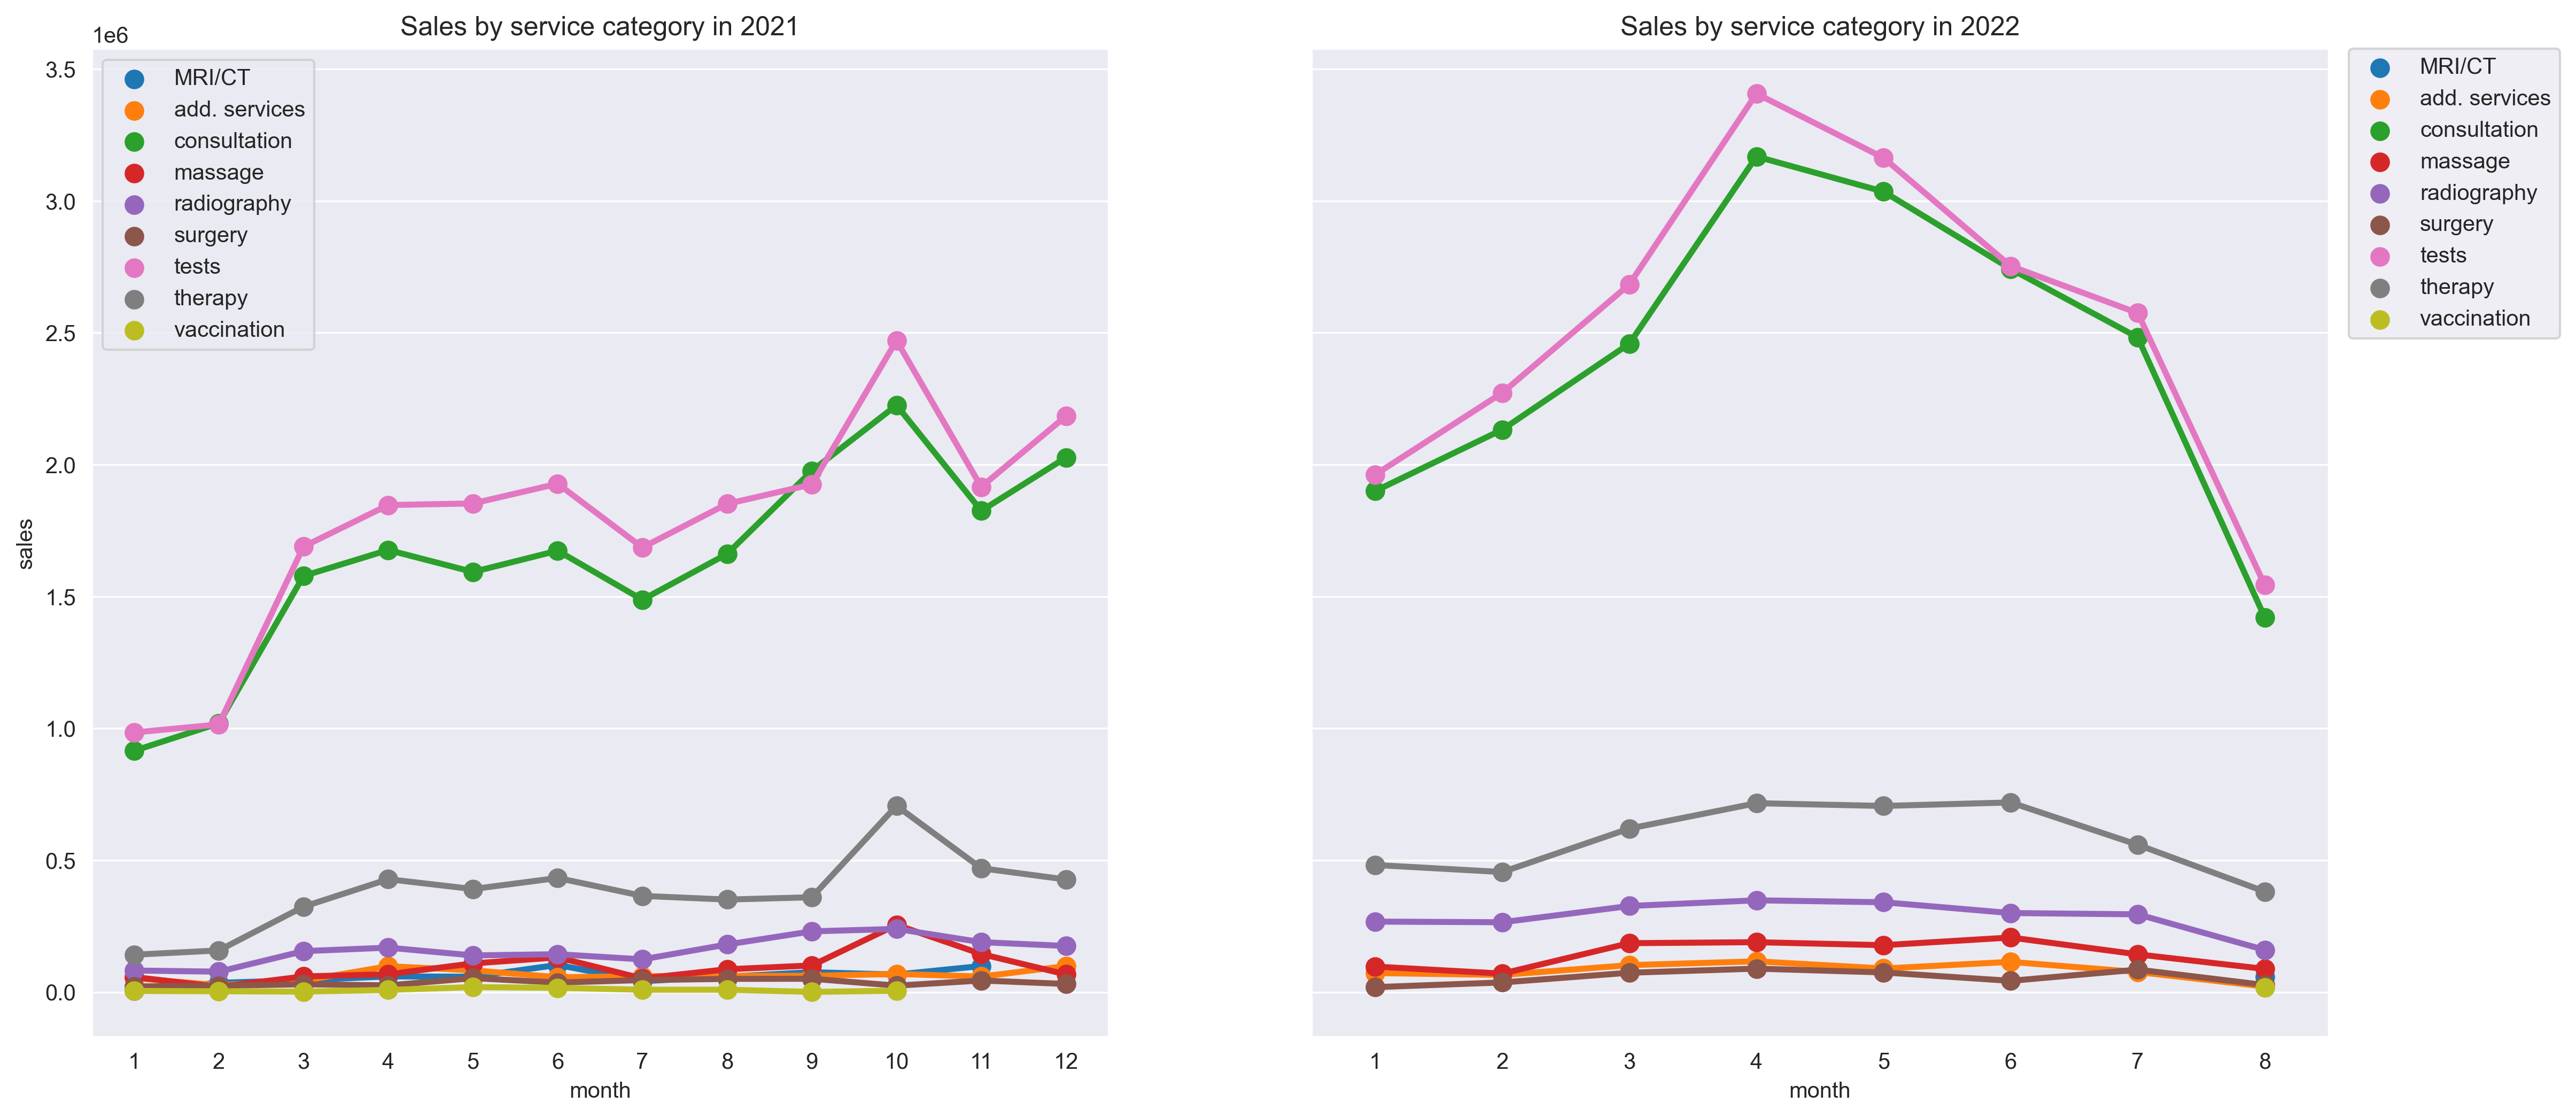

In [70]:
by_category_2021 = create_pivot(tmp_2021, 'service_amount', ['month', 'category'], 'sum').reset_index().sort_values(by='category')
by_category_2022 = create_pivot(tmp_2022, 'service_amount', ['month', 'category'], 'sum').reset_index().sort_values(by='category')

fig, ax =plt.subplots(1,2,dpi=300,sharey=True)
plot_pointplot(by_category_2021,by_category_2022,'month','service_amount','category','month','sales','Sales by service category','tab10')
ax[0].legend(loc='upper left')
ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.set_figwidth(18)
fig.set_figheight(8)

Similarly, we can see a decrease in sales by category from April 2022.

**Conclusion:** 
A higher churn rate can be caused by higher prices.

Also, we can make the second hypothesis saying **the average check changed due to a change in prices.**

In [71]:
avrg_by_category_2021 = create_pivot(tmp_2021, 'service_amount', 'service_name', 'mean').reset_index().sort_values(by='service_amount', ascending=False)
avrg_by_category_2022 = create_pivot(tmp_2022, 'service_amount', 'service_name', 'mean').reset_index().sort_values(by='service_amount', ascending=False)
avrg_by_category_2021 = pd.merge(avrg_by_category_2021, avrg_by_category_2022[['service_amount', 'service_name']], on='service_name', how='inner')
avrg_by_category_2021 = avrg_by_category_2021.rename(columns={'service_amount_x':'amount_2021','service_amount_y':'amount_2022'})
avrg_by_category_2021.head(15)

,service_name,amount_2021,amount_2022
0,Хирургическое удаление доброкачественной опухо...,7857.500000,8312.500000
1,Вскрытие панариция,7665.000000,8137.500000
2,Электронейромиография - игольчатая миография в...,7560.000000,3975.000000
3,МРТ плечевого сустава,7473.333333,7720.000000
4,Вскрытие абсцесса различной локализации,7016.818182,6804.000000
5,Вскрытие карбункула,6620.000000,6620.000000
6,Удаление атеромы,6615.000000,6950.000000
7,Удаление вросшего ногтя,6353.333333,6950.000000
8,Колоноскопия с забором биопсии,6286.400000,6614.444444
9,МРТ коленного сустава,6243.157895,9750.000000


**Conclusion:** 
From the table above, we can conclude that the price for most of the services increased which proves our second theory.

Let's check whether **the change in average price is caused by a change in the number of services provided.**

In [72]:
services = df['category'].unique()
for i in services:
    list_1 = tmp_2021[tmp_2021['category']==i]['service_name']
    list_2 = tmp_2022[tmp_2022['category']==i]['service_name']
    tmp = len(list_1.unique()) - len(list_2.unique())
    string = 'The number of services for ' + i
    if tmp > 0:
        string = string + ' decreased by'
        print(string, abs(tmp))
    elif tmp < 0:
        string = string + ' increased by'
        print(string, abs(tmp))
    else: 
        string = string + ' is the same'
        print(string)

The number of services for consultation increased by 5
The number of services for tests decreased by 50
The number of services for therapy increased by 3
The number of services for massage is the same
The number of services for radiography increased by 14
The number of services for surgery decreased by 3
The number of services for add. services increased by 3
The number of services for vaccination decreased by 5
The number of services for MRI/CT decreased by 19


**Conclusion:** 
The results are not certain since for some categories the number of services increased whereas for some the number actually decreased.

## Conclusion

- In 2021 COVID restrictions were lifted which can explain a gradual increase in the number of clients.

- From February 2022 the Russian currency got weaker which caused increased prices for goods and services. Since medical equipment and other necessary materials are mainly produced outside the country, medical centers had no option but to increase prices to afford to purchase supplies for the next quarter. In this reality, clients tried to finish all medical check-ups before significant price rises.

- As mentioned earlier, the main client base is 18-65 y.o. It is also the most solvent group of people. In 2022 there was a noticeable trend of people immigrating to other countries which explains a smaller number of clients starting from April 2022.